# Overview

You can add interactive controls in a panel. This allows you to create simple interactive apps, but also complex multi-page dashboards. We’ll start with a simple example of a function for drawing a sine wave with Matplotlib:

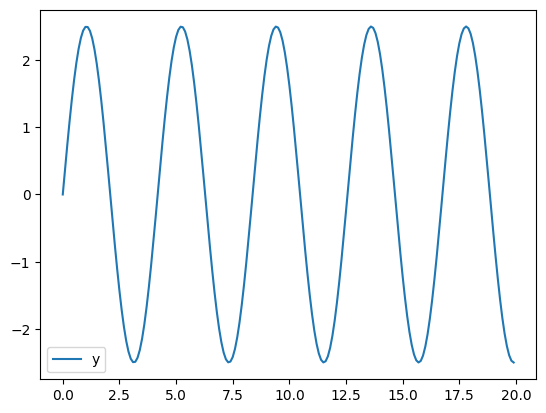

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline


def mplplot(df, **kwargs):
    fig = df.plot().get_figure()
    plt.close(fig)
    return fig


def sine(frequency=1.0, amplitude=1.0, n=200, view_fn=mplplot):
    xs = np.arange(n) / n * 20.0
    ys = amplitude * np.sin(frequency * xs)
    df = pd.DataFrame(dict(y=ys), index=xs)
    return view_fn(df, frequency=frequency, amplitude=amplitude, n=n)


sine(1.5, 2.5)

## Interactive panels

If we wanted to try many combinations of these values to understand how frequency and amplitude affect this graph, we could reevaluate the above cell many times. However, this would be a slow and tedious process. Instead of having to re-enter the values in the code each time, it is advisable to adjust the values interactively with the help of sliders. With such a panel app you can easily examine the parameters of a function. The function of `pn.interact` is similar to [ipywidgets interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html):

Column
    [0] Column
        [0] FloatSlider(end=3.0, name='frequency', start=-1.0, value=1.0)
        [1] FloatSlider(end=3.0, name='amplitude', start=-1.0, value=1.0)
        [2] IntSlider(end=600, name='n', start=-200, value=200)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00113')
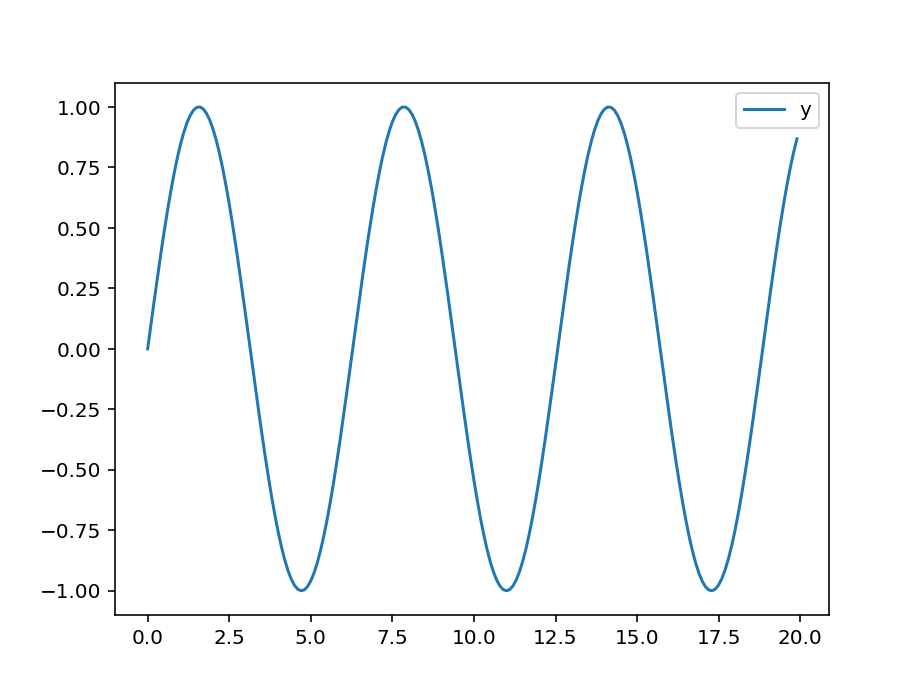

In [2]:
import panel as pn


pn.extension()

pn.interact(sine)

As long as a live Python process is running, dragging these widgets calls the `sine` callback function and evaluates the combination of parameter values ​​you selected and displays the results. With such a panel you can easily examine all functions that provide a visual result of a supported object type (see [Supported object types and libraries](https://github.com/holoviz/panel/issues/2), for example Matplotlib, Bokeh, Plotly, Altair or various text and image types.

## Components of panels 

`interact` is handy, but what if you want more control over how it looks or works? First, let’s see what `interact` is actually created by grabbing the object and viewing its representation:

In [3]:
i = pn.interact(sine, n=(5, 100))
print(i)

Column
    [0] Column
        [0] FloatSlider(end=3.0, name='frequency', start=-1.0, value=1.0)
        [1] FloatSlider(end=3.0, name='amplitude', start=-1.0, value=1.0)
        [2] IntSlider(end=100, name='n', start=5, value=200)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00154')


We can see here that the `interact` call has created an `pn.Column` object that consists of a WidgetBox (with 3 widgets) and a `pn.Row` Matplotlib figure. The control panel is compositional, so you can mix and match these components as you like by adding as many objects as needed:

Row
    [0] Matplotlib(Figure, name='interactive00154')
    [1] Column
        [0] Markdown(str)
        [1] FloatSlider(end=3.0, name='frequency', start=-1.0, value=1.0)
        [2] FloatSlider(end=3.0, name='amplitude', start=-1.0, value=1.0)
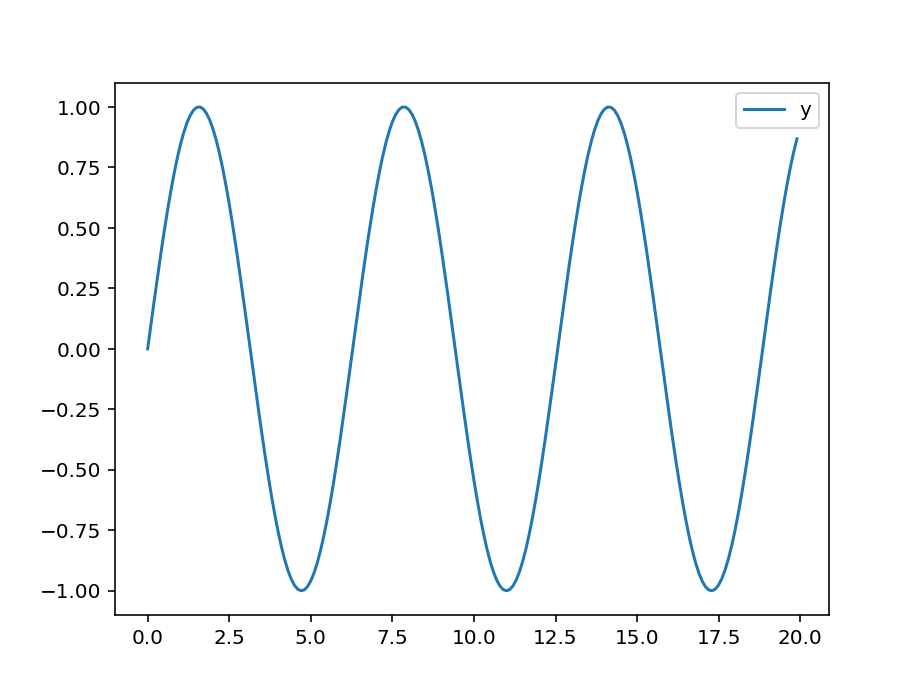

In [4]:
pn.Row(i[1][0], pn.Column("<br>\n# Sine waves", i[0][0], i[0][1]))

Note that the widgets remain linked to their plot, even if they are in a different notebook cell:

In [5]:
i[0][2]

IntSlider(end=100, name='n', start=5, value=200)

## New panels

With this compositional approach, you can combine different components such as widgets, charts, text and other elements that are needed for an app or a dashboard in any way you want. The `interact` example is based on a reactive programming model in which an input for the function changes and the control panel reactively updates the output of the function. `interact` is a handy way to automatically build widgets from the arguments for your function. However, Panel also provides a more explicit reactive API that allows you to define connections between widgets and function arguments, and then manually create the resulting dashboard from scratch.

In the following example we explicitly declare every component of an app:

1. Widgets
2. a function for calculating sine values
3. Column and row containers
4. the finished `sine_panel` app.

Widget objects have several parameters (current value, allowed ranges, etc.), and here we use the `depends` Panel decorator to declare that the input values of the function should come from the `value` parameters of the widgets. Now, when the function and widgets are displayed, the panel automatically updates the displayed output if one of the inputs changes:

Row
    [0] ParamFunction(function, _pane=Matplotlib, defer_load=False)
    [1] Column
        [0] Markdown(str)
        [1] FloatSlider(end=5, name='frequency', start=1.0, value=1)
        [2] FloatSlider(end=10, name='amplitude', start=0.1, value=1)
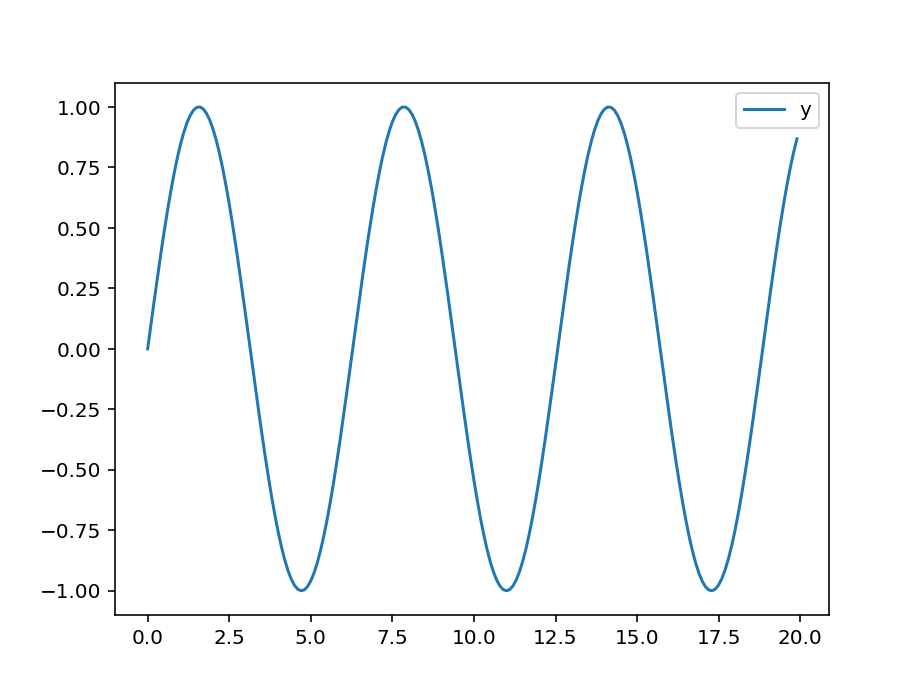

In [6]:
import panel.widgets as pnw


frequency = pnw.FloatSlider(name="frequency", value=1, start=1.0, end=5)
amplitude = pnw.FloatSlider(name="amplitude", value=1, start=0.1, end=10)


@pn.depends(frequency.param.value, amplitude.param.value)
def reactive_sine(frequency, amplitude):
    return sine(frequency, amplitude)


widgets = pn.Column("<br>\n# Sine waves", frequency, amplitude)
sine_panel = pn.Row(reactive_sine, widgets)

sine_panel

## Deploy panels

The above panels all work in a notebook cell, but unlike `ipywidgets` and other approaches, `Panel` apps work on standalone servers as well. The above app can, for example, be started as a separate web server with:

In [7]:
sine_panel.show()

Launching server at http://localhost:59683


This will start the Panel server and open a browser window with the application.

Or you can just indicate what you want to see on the website. `servable()`, and then the shell command to start a server with this object `pipenv run panel serve --show example.ipynb`:

In [8]:
sine_panel.servable();

The semicolon prevents another copy of the sine field from being displayed here in the notebook.

## Declarative Panels

The above compositional approach is very flexible, but it links domain-specific code (the parts about sine waves) to the widget display code. This is common in prototypical projects, but in projects where the code is going to be used in many different contexts, parts of the code that relate to the underlying domains (i.e. the application or research area) should be separated from those that are tied to certain display technologies (such as Jupyter notebooks or web servers).

For such uses, Panel supports objects that have been declared with the separate [Param](https://param.holoviz.org/) library. This offers a possibility to independently record and declare the parameters of your objects (code, parameters, application and dashboard technology). For example, the above code can be captured in an object that declares the ranges and values of all parameters as well as the generation of the diagram independently of the panel library or any other type of interaction with the object:

In [9]:
import param


class Sine(param.Parameterized):
    amplitude = param.Number(default=1, bounds=(0, None), softbounds=(0, 5))
    frequency = param.Number(default=2, bounds=(0, 10))
    n = param.Integer(default=200, bounds=(1, 200))

    def view(self):
        return sine(self.frequency, self.amplitude, self.n)


sine_obj = Sine()

The `Sine` class and `sine_obj` instance are not dependent on Panel, Jupyter or any other GUI or web toolkit – they simply declare facts about a particular domain (for example that sine waves take frequency and amplitude parameters and that the amplitude is a number greater or equals zero). That information is then enough for Panel to create an editable and viewable representation for this object without having to specify anything that depends on the domain-specific details contained in the `Sine` class and the `sine_obj` -Instance are not dependent on Panel, Jupyter or any other GUI or web toolkit. They simply declare facts about a certain range (for example, that sine waves take frequency and amplitude parameters, and that the amplitude is a number greater than or equal to zero). That information is enough for Panel to create an editable and viewable representation for this object without having to specify anything that depends on the domain-specific details contained outside of `sine_obj`:

Row
    [0] Column(margin=(5, 10), name='Sine')
        [0] StaticText(value='<b>Sine</b>')
        [1] FloatSlider(end=5, name='Amplitude', value=1)
        [2] FloatSlider(end=10, name='Frequency', value=2)
        [3] IntSlider(end=200, name='N', start=1, value=200)
    [1] ParamMethod(method, _pane=Matplotlib, defer_load=False)
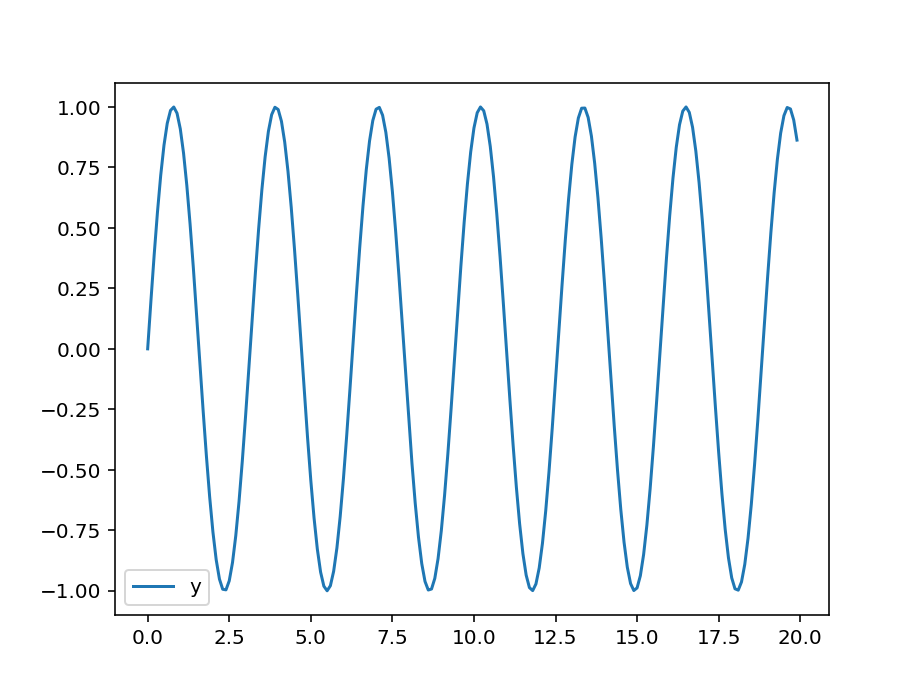

In [10]:
pn.Row(sine_obj.param, sine_obj.view)

In order to support a certain domain, you can create hierarchies of such classes, in which all parameters and functions are summarised that you need for different object families. Both parameters and code are adopted in the classes, regardless of a specific GUI library or even the existence of a GUI at all. This approach makes it convenient to maintain a large code base that can be fully viewed and edited with Panel, in a way that can be maintained and customised over time.

## Linking plots and actions between panels

The above approaches each work with a variety of displayable objects, including images, equations, tables, and charts. In each case, the panel provides interactive functionality using widgets and updates the objects displayed accordingly, making very few assumptions about what is actually displayed. Panel also supports a broader and more dynamic interactivity in which the displayed object itself is interactive, for example JavaScript-based diagrams of Bokeh and Plotly.

For example, if we replace the matplotlib wrapper that came with pandas with the [Bokeh](https://docs.bokeh.org/en/latest/) wrapper [hvPlot](https://hvplot.holoviz.org/), we automatically get interactive plots that allow *zooming*, *panning* and *hovering*:

In [11]:
import hvplot.pandas


def hvplot(df, **kwargs):
    return df.hvplot()


pn.interact(sine, view_fn=hvplot)

Column(sizing_mode='fixed')
    [0] Column
        [0] FloatSlider(end=3.0, name='frequency', start=-1.0, value=1.0)
        [1] FloatSlider(end=3.0, name='amplitude', start=-1.0, value=1.0)
        [2] IntSlider(end=600, name='n', start=-200, value=200)
    [1] Row(sizing_mode='fixed')
        [0] HoloViews(Curve, height=300, name='interactive00996', sizing_mode='fixed', width=700)

These interactive actions can be combined with more complex interactions in a plot (for example `tap`, `hover`) to make it easier to explore data and uncover connections. For example, we can use HoloViews to create a more comprehensive version of the hvPlot example that is dynamically updated to show the position on the circle as we hover over the sine curve:

In [12]:
import holoviews as hv


tap = hv.streams.PointerX(x=0)


def hvplot2(df, frequency, **kwargs):
    plot = df.hvplot(width=500, padding=(0, 0.1))
    tap.source = plot

    def unit_circle(x):
        cx = np.cos(x * frequency)
        sx = np.sin(x * frequency)
        circle = hv.Path(
            [hv.Ellipse(0, 0, 2), [(-1, 0), (1, 0)], [(0, -1), (0, 1)]]
        ).opts(color="black")
        triangle = hv.Path(
            [[(0, 0), (cx, sx)], [(0, 0), (cx, 0)], [(cx, 0), (cx, sx)]]
        ).opts(color="red", line_width=2)
        labels = hv.Labels(
            [(cx / 2, 0, "%.2f" % cx), (cx, sx / 2.0, "%.2f" % sx)]
        )
        labels = labels.opts(
            padding=0.1, xaxis=None, yaxis=None, text_baseline="bottom"
        )
        return circle * triangle * labels

    vline = hv.DynamicMap(hv.VLine, streams=[tap]).opts(color="black")

    return (plot * vline).opts(toolbar="right")


unit_curve = pn.interact(
    sine, view_fn=hvplot2, n=(1, 200), frequency=(0, 10.0)
)

pn.Column(
    pn.Row(
        "# The Unit Circle",
        pn.Spacer(width=45),
        unit_curve[0][0],
        unit_curve[0][2],
    ),
    unit_curve[1],
)

Column
    [0] Row
        [0] Markdown(str)
        [1] Spacer(width=45)
        [2] FloatSlider(end=10.0, name='frequency', value=1.0)
        [3] IntSlider(end=200, name='n', start=1, value=200)
    [1] Row(sizing_mode='fixed')
        [0] HoloViews(DynamicMap, height=300, name='interactive01145', sizing_mode='fixed', width=500)